In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from publicdata.chis import *

%matplotlib inline
sns.set_context('notebook')
idx = pd.IndexSlice # Convenience redefinition. 


In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()
pkg

In [3]:
def recode(df):
    """ Recode to a simpler group of races.  For a lot of health outcomes, the major divisions are
    * White + Asian ( whasian )
    * Black + Latino Afrotino
    * Others
    """
    
    from pandas.api.types import CategoricalDtype
    
    df['race_recode'] = df.racedf_p1
    df.replace({'race_recode':{
        'NON-LATINO WHITE':'white',
        'NON-LATINO ASIAN':'asian',
        'NON-LATINO AMERICAN INDIAN/ALASKAN NATIVE': 'other',
        'NON-LATINO AFR. AMER.': 'black',
        'LATINO': 'latino',
        'NON-LATINO, TWO+ RACES': 'other',
        'NON-LATINO OTHER, ONE RACE': 'other'
    }}, inplace=True)
    df.race_recode = df.race_recode.astype('category')
    
    df['race_recode_3'] = df.racedf_p1
    df.replace({'race_recode_3':{
        'NON-LATINO WHITE':'white_asian',
        'NON-LATINO ASIAN':'white_asian',
        'NON-LATINO AMERICAN INDIAN/ALASKAN NATIVE': 'other',
        'NON-LATINO AFR. AMER.': 'black_latino',
        'LATINO': 'black_latino',
        'NON-LATINO, TWO+ RACES': 'other',
        'NON-LATINO OTHER, ONE RACE': 'other'
    }}, inplace=True)
    df.race_recode_3 = df.race_recode.astype('category')
    
    df['minority'] = (df['race_recode'] != 'white_asian').astype(int)
    
    
    df['old'] = (df.srage_p1 < '45-49 YEARS').astype(CategoricalDtype(categories=[False, True],ordered=True))
    df.old.cat.rename_categories(['OLD','YOUNG'], inplace=True)

    df['poor'] = (df.povll.isin(('200-299% FPL', '300% FPL AND ABOVE')) )\
        .astype(CategoricalDtype(categories=[True, False],ordered=True))
    df.poor.cat.rename_categories(['NPOV','POV'], inplace=True)

    return df


In [4]:
df17 = pkg.reference('adult_2017').dataframe()
df16 = pkg.reference('adult_2016').dataframe()
df15 = pkg.reference('adult_2015').dataframe()
df14 = pkg.reference('adult_2014').dataframe()
df13 = pkg.reference('adult_2013').dataframe()

# Rename some categories. 2016 and 2015 have "ALASKA" where the others have "ALASKAN", which 
# causes the concat() operation to convert categories to strings
cats_17 = df17.racedf_p1.cat.categories
cat_map = dict(zip(df16.racedf_p1.cat.categories, df17.racedf_p1.cat.categories))

for e in [df13,df14,df15,df16,df17]:
    e.racedf_p1.cat.rename_categories(cat_map, inplace=True)
    
for df, year in zip([df13, df14, df15, df16, df17], range(2013, 2018)):
    df['year'] = year
    
    df = recode(df)

In [5]:
# Pool two years of data. These are the only two that have ak22_p1, 
#  "HH TOTAL ANN. INC BEFORE TAXES IN 2014/2015 (PUF 1 YR RECODE)"

df = pd.concat([
        select_columns(df17, ['diabetes', 'ak22_p1']),
        select_columns(df16, ['diabetes', 'ak22_p1'])]).reset_index()

n_years = 2

# Need to divide all of the weights by 2
weight_cols = [c for c in df.columns if 'raked' in c]

df.loc[:,weight_cols] /= n_years
len(df)

42208

In [6]:

t = chis_segment_estimate(df, 'diabetes')
t = t.loc[idx[('diabetes_pct','diabetes_count','diabetes_rse'),'YES'], #rows
          idx[:] # columns
         ]

t = t.unstack('measure')
t.columns = t.columns.droplevel()

t['diabetes_count'] /=  n_years
t

measure,diabetes_count,diabetes_pct,diabetes_rse
diabetes,,,
YES,1.451790e+06,9.9,3.8


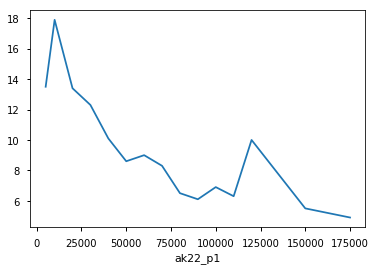

In [7]:
# Diabetes rates vs income. 
t = chis_segment_estimate(df, 'diabetes', 'ak22_p1')
# Now we can select with the two indexers. 
t = t.loc[idx[:,('diabetes_pct','diabetes_count','diabetes_rse'),'YES'], #rows
          idx[:] # columns
         ]

t = t.unstack('measure')

# The columns are multi-level, but there is only one value for the first level, 
# so it is useless. 
t.columns = t.columns.droplevel()

# We already selected for the single value of 'YES', so this level is useless too
t.index = t.index.droplevel('diabetes')

def split_range(v):
    if '-' in v:
        p = v.split('-')
        return int(p[0].replace(',',''))
    else:
        p = v.split()
        # -1 so "10,000" is not equal to "<10,000"
        return int(p[-1].replace(',',''))-5000
    
t = t.rename(mapper=split_range, axis='index')

t[t.diabetes_rse<=30].sort_index().diabetes_pct.plot()


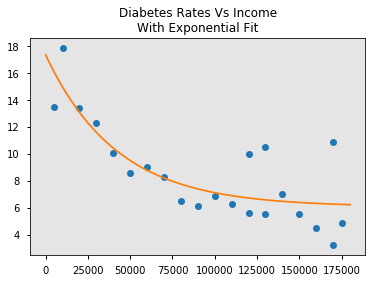

In [8]:
from matplotlib import pylab
from scipy.optimize import curve_fit
import plotly.plotly as py

def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c

t = t.sort_index().reset_index()

x = t.ak22_p1
y = t.diabetes_pct

popt, pcov = curve_fit(exponenial_func, x, y, p0=(1, 1e-6, 1))

xx = np.linspace(0, 180000, 500)
yy = exponenial_func(xx, *popt)

plt.plot(x,y,'o', xx, yy)
pylab.title('Diabetes Rates Vs Income\nWith Exponential Fit')
ax = plt.gca()
ax.set_facecolor((0.898, 0.898, 0.898))
fig = plt.gcf()


In [9]:
popt

array([1.12899227e+01, 2.37719728e-05, 6.07291799e+00])

In [10]:
perr = np.sqrt(np.diag(pcov))
perr/popt

array([0.16837275, 0.42169253, 0.16457238])

# Poverty, Age and Race

Clearly, the most important factor in diabetes rates in age


In [11]:

n_years, df = chis_concat([df17,df16,df15], ['diabetes', 'race_recode', 'racedf_p1', 'poor', 'old'])

t = process_segments(df, 'diabetes', 'YES', ['old', 'poor','race_recode'])
t.diabetes_count /= n_years
t = t.reset_index().sort_values('diabetes_pct')
t[t.diabetes_rse < 30]

measure,race_recode,poor,old,diabetes_count,diabetes_pct,diabetes_rse
17,white,NPOV,YOUNG,16350.145525,1.4,22.4
1,asian,NPOV,YOUNG,14811.581952,2.4,27.9
9,latino,NPOV,YOUNG,25101.715734,2.7,27.6
19,white,POV,YOUNG,11221.872617,3.5,28.3
11,latino,POV,YOUNG,53941.136343,4.8,17.7
16,white,NPOV,OLD,207666.517921,9.8,5.0
12,other,NPOV,OLD,10843.759849,12.9,22.6
0,asian,NPOV,OLD,55098.808223,14.4,18.0
4,black,NPOV,OLD,34079.879348,18.1,16.9
8,latino,NPOV,OLD,112671.763648,18.6,9.1


## Log regression

In [12]:

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e9)

n_years, df = chis_concat([df17,df16,df15], ['diabetes', 'srsex', 'srage_p1', 'racedf_p1', 'race_recode', 'povll', 'minority', 'poor', 'old'])

def age_group_parts(v):
    try:
        y1, y2, _ = v.replace('-',' ').split()
        return y1,y2
    except ValueError:
        # Probably '85+ YEARS'
        return 85, 120



def age_group_to_age(v):
    y1, y2 = age_group_parts(v)
    if y1 == 85:
        return 85
    else:
        return (int(y1)+int(y2))/2


pov_mid_map = {
    "0-99% FPL": 50,
    "100-199% FPL": 150,
    "200-299% FPL":250,
    "300% FPL AND ABOVE": 400
}

pov_status_map = {
    "0-99% FPL": 1,
    "100-199% FPL": 0,
    "200-299% FPL":0,
    "300% FPL AND ABOVE": 0
}


df = pd.get_dummies(df, columns=['race_recode'], prefix='', prefix_sep = '')

df['diabetes_bool'] = (df.diabetes == 'YES').astype(int)
df['group_age_mean'] = df.srage_p1.apply(lambda v:age_group_to_age(v)).astype(float)
df['group_age_min'] = df.srage_p1.apply(lambda v:age_group_parts(v)[0]).astype(int)
df['group_age_max'] = df.srage_p1.apply(lambda v:age_group_parts(v)[1]).astype(int)

df['mid_povll'] = df.povll.apply(lambda v: pov_mid_map[v])
df['pov'] = df.povll.apply(lambda v: pov_status_map[v])
df['poor_bool'] = (df.poor == 'POV').astype(int)
df['is_male'] = (df.srsex == 'MALE').astype(int)

#X = df[['avg_group_age', 'minority', 'mid_povll']]
X = df[['group_age_mean',  'mid_povll', 'is_male', 'asian','white','black','latino','other']]
#X = df[['avg_group_age',  'mid_povll']]
y = df['diabetes_bool']

logreg.fit(X, y)

df['lr_prob'] = logreg.predict_proba(X)[:, 1]

logreg.coef_,  df['lr_prob'].sum(), df['diabetes_bool'].sum(), sum(df.diabetes == 'YES')

(array([[ 0.04475781, -0.00198462,  0.37597614, -0.84606202, -1.17699891,
         -0.40336332, -0.37034146, -0.61479478]]),
 7750.707946601157,
 7750,
 7750)

In [13]:
df.head()

,index,diabetes,srsex,srage_p1,racedf_p1,povll,minority,poor,old,rakedw0,...,white,diabetes_bool,group_age_mean,group_age_min,group_age_max,mid_povll,pov,poor_bool,is_male,lr_prob
0,0,NO,FEMALE,70-74 YEARS,NON-LATINO WHITE,200-299% FPL,1,NPOV,OLD,12.380612,...,1,0,72.0,70,74,250,0,0,0,0.134452
1,1,NO,MALE,65-69 YEARS,NON-LATINO WHITE,300% FPL AND ABOVE,1,NPOV,OLD,216.417872,...,1,0,67.0,65,69,400,0,0,1,0.118401
2,2,NO,MALE,80-84 YEARS,NON-LATINO WHITE,300% FPL AND ABOVE,1,NPOV,OLD,112.672832,...,1,0,82.0,80,84,400,0,0,1,0.208121
3,3,NO,MALE,60-64 YEARS,NON-LATINO WHITE,100-199% FPL,1,POV,OLD,198.559016,...,1,0,62.0,60,64,150,0,1,1,0.149912
4,4,YES,FEMALE,60-64 YEARS,NON-LATINO WHITE,300% FPL AND ABOVE,1,NPOV,OLD,256.148161,...,1,1,62.0,60,64,400,0,0,0,0.068662


In [31]:
(df.rakedw0*df.lr_prob).sum()


2975892.4074465665

In [15]:
# Races and the on-hot encoding for them. 
races = (
    ('white', (1,0,0,0,0)),
    ('asian', (0,1,0,0,0)),
    ('black', (0,0,1,0,0)),
    ('latino',(0,0,0,1,0)),
    ('other', (0,0,0,0,1)),
)

l = []

for age in range(18,85):
    for pov in range(0,400,10):
        for sex in (1,0):
            for race_name, race_ohe in races:
                l.append( (age, pov, sex,race_name) + race_ohe )
                
rasp = pd.DataFrame(l, columns = 'age pov sex raceeth asian white black latino other'.split())

# The first column ( [:,0]) is the probability of *not* having diabetes. 
cols = [ c for c in rasp.columns if c!= 'raceeth' ]
rasp['prob'] = logreg.predict_proba(rasp[cols])[:,1]

# Get rid of the one-hot columns 
rasp = rasp['age pov sex raceeth prob'.split()]

rasp.head()


,age,pov,sex,raceeth,prob
0,18,0,1,white,0.044108
1,18,0,1,asian,0.032079
2,18,0,1,black,0.067025
3,18,0,1,latino,0.069120
4,18,0,1,other,0.054954


In [16]:
rasp.groupby('raceeth').prob.mean()

raceeth
asian     0.100538
black     0.184821
latino    0.189307
other     0.157859
white     0.131815
Name: prob, dtype: float64

In [17]:
rasp.sort_values('prob', ascending = True).head()

,age,pov,sex,raceeth,prob
396,18,390,0,asian,0.010385
386,18,380,0,asian,0.010591
376,18,370,0,asian,0.010801
796,19,390,0,asian,0.010856
366,18,360,0,asian,0.011015


In [18]:
rasp.prob.describe()

count    26800.000000
mean         0.152868
std          0.114989
min          0.010385
25%          0.059406
50%          0.118095
75%          0.222134
max          0.587522
Name: prob, dtype: float64

In [19]:
rasp.prob.sum()

4096.862981795822

In [20]:
logreg = LogisticRegression(C=1e9)

X = df[['group_age_mean', 'pov', 'is_male', 'asian','white','black','latino','other']]
y = df['diabetes_bool']

logreg.fit(X, y)

l = []

# Convert to census age ranges
census_age_ranges = [
    pd.Interval(18, 24, closed='both'),
    pd.Interval(25, 34, closed='both'),
    pd.Interval(35, 44, closed='both'),
    pd.Interval(45, 54, closed='both'),
    pd.Interval(55, 64, closed='both'),
    pd.Interval(65, 74, closed='both'),
    pd.Interval(75, 120, closed='both')
]

for age_range in census_age_ranges:
    age =( age_range.left + age_range.right)/2
    for pov in (1,0):
        for sex in (1,0):
            for race_name, race_ohe in races:
                l.append( (age, age_range.left, age_range.right, pov, sex, race_name) + race_ohe )
                
t = pd.DataFrame(l, columns = 'age age_min age_max pov sex raceeth asian white black latino other'.split())

cols = [ c for c in t.columns if c not in  ['raceeth', 'age_min','age_max' ] ]
t['prob'] = logreg.predict_proba(t[cols])[:,1] # The first column ( [:,0]) is the probability of *not* having diabetes. 

t.head()

# Get rid of the one-hot columns 
t = t['age age_min age_max pov sex raceeth prob'.split()]

rasp_reduced = t

rasp_reduced.head()

,age,age_min,age_max,pov,sex,raceeth,prob
0,21.0,18,24,1,1,white,0.042474
1,21.0,18,24,1,1,asian,0.029804
2,21.0,18,24,1,1,black,0.066237
3,21.0,18,24,1,1,latino,0.072074
4,21.0,18,24,1,1,other,0.054269


In [21]:
len(rasp_reduced)

140